In [1]:
%matplotlib widget

import backtrader as bt
from backtradermql5.mt5store import MTraderStore
from datetime import datetime, timedelta
from local.ind_supertrend import SuperTrend

In [2]:
class MyStrategy(bt.Strategy):
    params = (
        ('mt5broker', False),
        ('stperiod', 7),
        ('stmultiplier', 3),
        ('doprint', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if doprint or self.params.doprint:
            #dt = dt or self.datas[0].datetime.datetime()
            dt = dt or self.data.datetime.datetime()
            print(f'{dt}: {txt}')

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.data1close = self.datas[1].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.inBuyPosition = False
        self.inSellPosition = False
        self.live_data = False
        self.last2ST = 0
        #self.activetradeid = None
        #global buy_order 
        #self.bar_executed = 0

        self.x = SuperTrend(self.datas[1],
                            period=self.params.stperiod,
                            multiplier=self.params.stmultiplier,
                            plot=True)
        
        # the indicator should be based on the higher time frame 
        self.stcross = bt.ind.CrossOver(self.x, self.data1close)

        super().__init__()
        #self.broker.set_coc(True)

    def notify_order(self, order):

        if order.status in [order.Submitted]:
            self.log('Order submitted')
            return
        if order.status in [order.Accepted]:
            self.log('Order accepted')
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,
                          order.executed.comm))

            elif order.issell():
                self.log('SELL EXECUTED, Price: %.5f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            # capture the trade id
            self.log('Notify trade: trade is not closed')
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # get pos and dpos parameter
        pos = self.getposition(self.data)
        dpos = pos.size
        #self.log('Close, %.5f, Pos size: %.5f' % (self.dataclose[0], dpos))

        cash = self.broker.getcash()
        #if self.live_data:
        #    cash = self.broker.getcash()
        #else
        #    cash = 'NA'

        # for multiple data
        #for data in self.datas:
        #    self.log(f'{data._name} | Cash {cash} | O: {data.open[0]} H: {data.high[0]} L: {data.low[0]} C: {data.close[0]} V:{data.volume[0]} Pos:{dpos}')
        data = self.data
        self.log(f'{data._name} | Cash {cash} | O: {data.open[0]} H: {data.high[0]} L: {data.low[0]} C: {data.close[0]} V:{data.volume[0]} Pos:{dpos}')
        
        # Check if we are in the market
        #if not self.position:
        ''' Test strategy '''
        #### simple strategi from cerebro (just for test.. )
        '''
        if not dpos:
            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.dataclose[-1]:
                    # current close less than previous close

                # BUY, BUY, BUY!!! (with default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                if self.live_data or not self.params.mt5broker: 
                    self.order = self.buy() 
                    self.buy_order = self.order

        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 2):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                # self.order = self.sell()
                if self.live_data or not self.params.mt5broker: 
                    self.cancel(self.buy_order) # this supposed to close it..
                    #self.close() # this supposed to close it..
        '''
        ####
        if not dpos:
            # Not yet ... we MIGHT BUY if
            if (self.stcross < 0) or ((self.data1close[0] > self.last2ST)
                                      and self.last2ST != 0):
                self.log('BUY CREATE1, %.5f' % self.data1close[0])
                if self.live_data or not self.params.mt5broker: 
                    #self.order = self.buy()
                    self.order = self.buy_bracket(exectype=bt.Order.Market, stopprice=1.32724)
                self.inBuyPosition = True

            # if supertrend  is crossing..or
            if (self.stcross > 0) or ((self.data1close[0] < self.last2ST)
                                      and self.last2ST != 0):
                self.log('SELL CREATE1, %.5f' % self.data1close[0])
                if self.live_data or not self.params.mt5broker: 
                    self.order = self.sell()
                    #self.order = self.sell_bracket(exectype=bt.Order.Market, stopprice=self.last2ST)
                self.inSellPosition = True
            
        else:
            # Already in the market ..  # this can be simplified .. no need inbuy/insell position now.. since we have .close()
            if self.inBuyPosition == True:
                # close position if..
                if self.stcross > 0 and dpos >= 0:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE2, %.5f' % self.data1close[0])

                    if self.live_data: 
                        self.order = self.cancel(self.order) # self.trade.tradeid)
                    elif not self.params.mt5broker:
                        self.order = self.close() # self.trade.tradeid)

                    #if self.live_data or not self.params.mt5broker: 
                        #self.order = self.close(tradeid=self.activetradeid) # self.trade.tradeid)

                    self.inBuyPosition = False
                    self.last2ST = self.x[0]  

            if self.inSellPosition == True:
                # close position if..
                if self.stcross < 0 and dpos <= 0:
                    # BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE2, %.5f' % self.data1close[0])

                    if self.live_data: 
                        self.order = self.cancel(self.order) # self.trade.tradeid)
                    elif not self.params.mt5broker:
                        self.order = self.close() # self.trade.tradeid)

                    #if self.live_data or not self.params.mt5broker: 
                        #self.order = self.close(tradeid=self.activetradeid) #self.trade.tradeid)
                    #    self.order = self.cancel(self.order) # self.trade.tradeid)

                    self.inSellPosition = False
                    self.last2ST = self.x[0]  

    def notify_data(self, data, status, *args, **kwargs):
        dn = data._name
        dt = datetime.now()

        self.log('Data Status: %s' % data._getstatusname(status), dt=dt)
        if data._getstatusname(status) == 'LIVE':
            self.live_data = True
        else:
            self.live_data = False

#    def notify_store(self, msg): # is it causing the trouble?
#        self.log('Notify store: %s' % msg)
        
    def stop(self):
        self.log('(ST (period,mul): %2d, %2d) Ending Value %.2f'
            % (self.params.stperiod, self.params.stmultiplier, self.broker.getvalue()), 
                 doprint=True)
    

In [3]:
def runstrat(ppair='EURUSD',
             ptf=bt.TimeFrame.Minutes,
             pcomp=5,
             ptf1=bt.TimeFrame.Minutes,
             pcomp1=30,
             pstart_date="2020-03-21",
             pend_date="2020-03-22",
             phost='192.168.100.110',
             pdebug=False,
             phistory=False,
             pmt5broker=False,
             psizer_type=bt.sizers.FixedSize,
             pcash=10000,
             pstake=1,
             pcommission=15,
             pmargin=1000,
             pmult=100000,
             pplot=True,
             panalyze=True,
             pstrategy=MyStrategy,
             pstperiod=7,
             pstmultiplier=3,
             pdoprint=False,
             p_usepositions=True,
             optimize=False):
#             pma1period=5,
#             pma2period=10,
#             pma3period=15,
#             patrperiod=20,

    cerebro = bt.Cerebro()
    store = MTraderStore(host=phost, debug=pdebug)

    if pmt5broker:
        broker = store.getbroker(use_positions=p_usepositions) # 
        cerebro.setbroker(broker)

        data = store.getdata(dataname=ppair,
                         timeframe=ptf,
                         compression=pcomp,
                         fromdate=pstart_date,
                         historical=False)
    else:
        data = store.getdata(dataname=ppair,
                         timeframe=ptf,
                         compression=pcomp,
                         fromdate=pstart_date,
                         todate=pend_date,
                         historical=True)
#                             - timedelta(hours=5),

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    if pcomp1:
        cerebro.resampledata(data, timeframe=ptf1, compression=pcomp1)
    
    # set sizer
    cerebro.addsizer(psizer_type, stake=pstake)

    #----- Normal Strategy
    #cerebro.addstrategy(MyStrategy, ma1period=5, ma2period=10, ma3period=17, atrperiod=10)
    #    pstrategy,
    if optimize == True:
        strats = cerebro.optstrategy(pstrategy,
                                     stperiod=range(5,12),
                                     stmultiplier=range(5,12))
                                     #stperiod=range(5,9),
                                     #stmultiplier=range(6,10))
    else:
        cerebro.addstrategy(pstrategy,
                            stperiod=pstperiod,
                            stmultiplier=pstmultiplier,
                            mt5broker=pmt5broker,
                            doprint=pdoprint
                           )

    #----- Set commission
    cerebro.broker.setcommission(commission=pcommission,
                                 margin=pmargin,
                                 mult=pmult)

    # test analyzer
    if panalyze:
        cerebro.addanalyzer(bt.analyzers.TimeReturn,
                            timeframe=bt.TimeFrame.Years)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                            timeframe=bt.TimeFrame.Years)
        cerebro.addanalyzer(bt.analyzers.SQN, )

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    if not optimize:
        results = cerebro.run()
        #results = cerebro.run(maxcpus=1, stdstats=False)
    else:
        results = cerebro.run(maxcpus=1, stdstats=False)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    if pplot and not(optimize): 
        cerebro.plot(style='candlestick', volume=True)

    if panalyze:
        strat = results[0]
        # Results of own analyzers
        al = strat.analyzers.timereturn
        print('-- Time Return:')
        for k, v in al.get_analysis().items():
            print('{}: {}'.format(k, v))

        al = strat.analyzers.sharperatio
        print('-- Sharpe Ratio:')
        for k, v in al.get_analysis().items():
            print('{}: {}'.format(k, v))

        al = strat.analyzers.sqn
        print('-- SQN:')
        for k, v in al.get_analysis().items():
            print('{}: {}'.format(k, v))

Starting Portfolio Value: 10000.00
2020-03-27 07:55:34.097907: Data Status: DELAYED
2019-12-11 09:00:00: GBPUSD | Cash 10000.0 | O: 1.31318 H: 1.3136 L: 1.31224 C: 1.31254 V:1183.0 Pos:0
2019-12-11 09:30:00: GBPUSD | Cash 10000.0 | O: 1.31253 H: 1.31261 L: 1.31131 C: 1.31152 V:1410.0 Pos:0
2019-12-11 10:00:00: GBPUSD | Cash 10000.0 | O: 1.31152 H: 1.31193 L: 1.31114 C: 1.31185 V:1642.0 Pos:0
2019-12-11 10:30:00: GBPUSD | Cash 10000.0 | O: 1.31185 H: 1.31468 L: 1.31171 C: 1.31378 V:2010.0 Pos:0
2019-12-11 11:00:00: GBPUSD | Cash 10000.0 | O: 1.31378 H: 1.31482 L: 1.31354 C: 1.31462 V:1239.0 Pos:0
2019-12-11 11:30:00: GBPUSD | Cash 10000.0 | O: 1.31462 H: 1.31568 L: 1.31381 C: 1.31382 V:1752.0 Pos:0
2019-12-11 12:00:00: GBPUSD | Cash 10000.0 | O: 1.31382 H: 1.31511 L: 1.31376 C: 1.31437 V:1334.0 Pos:0
2019-12-11 12:30:00: GBPUSD | Cash 10000.0 | O: 1.31437 H: 1.31562 L: 1.31418 C: 1.3153 V:1172.0 Pos:0
2019-12-11 13:00:00: GBPUSD | Cash 10000.0 | O: 1.3153 H: 1.31588 L: 1.31479 C: 1.3148

2019-12-13 11:00:00: GBPUSD | Cash 4541.000000000006 | O: 1.34043 H: 1.34043 L: 1.33572 C: 1.33824 V:3005.0 Pos:1
2019-12-13 11:30:00: GBPUSD | Cash 4869.999999999985 | O: 1.33823 H: 1.34203 L: 1.33823 C: 1.34153 V:2467.0 Pos:1
2019-12-13 12:00:00: GBPUSD | Cash 4683.000000000004 | O: 1.34154 H: 1.34183 L: 1.33928 C: 1.33966 V:1917.0 Pos:1
2019-12-13 12:30:00: GBPUSD | Cash 4637.999999999997 | O: 1.33968 H: 1.34022 L: 1.33761 C: 1.33921 V:1951.0 Pos:1
2019-12-13 13:00:00: GBPUSD | Cash 4627.999999999998 | O: 1.33921 H: 1.33947 L: 1.33803 C: 1.33911 V:1797.0 Pos:1
2019-12-13 13:30:00: GBPUSD | Cash 4595.000000000004 | O: 1.33908 H: 1.34037 L: 1.33868 C: 1.33878 V:1372.0 Pos:1
2019-12-13 14:00:00: GBPUSD | Cash 4568.000000000005 | O: 1.33876 H: 1.33948 L: 1.33837 C: 1.33851 V:1352.0 Pos:1
2019-12-13 14:30:00: GBPUSD | Cash 4598.999999999985 | O: 1.33854 H: 1.33914 L: 1.33798 C: 1.33882 V:1653.0 Pos:1
2019-12-13 15:00:00: GBPUSD | Cash 4415.000000000001 | O: 1.33882 H: 1.33897 L: 1.33654 

<IPython.core.display.Javascript object>


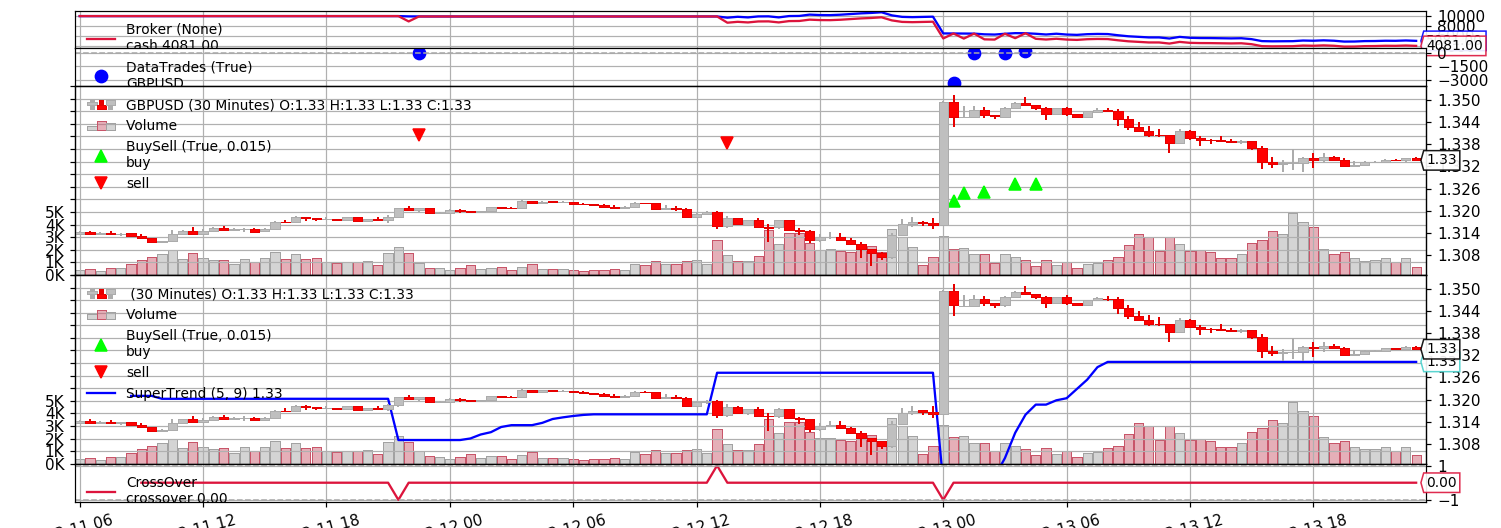

In [11]:
%matplotlib widget
#         ptf1=bt.TimeFrame.Minutes,
#         pcomp1=240,
#         pstart_date=1585047600,
#         phistory=False,

runstrat(ppair='GBPUSD',
         ptf=bt.TimeFrame.Minutes,
         pcomp=30,
         ptf1=bt.TimeFrame.Minutes,
         pcomp1=30,
         pstart_date=datetime.now() - timedelta(days=107) - timedelta(hours=2),
         pend_date=datetime.now() - timedelta(days=102) - timedelta(hours=20),
         phost='192.168.100.113',
         pdebug=False,
         pmt5broker=False,
         pplot=True,
         pdoprint = True,
         p_usepositions = False,
         psizer_type=bt.sizers.FixedSize,
         pcash=10000,
         pstake=1,
         pcommission=15,
         pmargin=1000,
         pmult=100000,
         panalyze=False,
         pstrategy=MyStrategy,
         pstperiod=5,
         pstmultiplier=9,
         optimize = False
        ) 
         #pstperiod=6, 10
         #pstmultiplier=9, 11
         #pma1period=5,
         #pma2period=9,
         #pma3period=15,
         #pstrategy=superTrendStrategy,
         #pstrategy=MyStrategy, (don't forget to enable the xxxperiod param in addStrategy, FIX this!)

            # tf=1, period=3,multiplier=3
            

# EURUSD 
# 30min timeframe
period, mult => 6,9
# day 20-0
Starting Portfolio Value: 10000.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  6) Ending Value 14776.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  7) Ending Value 15308.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  8) Ending Value 14970.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  9) Ending Value 14588.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  6) Ending Value 15495.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  7) Ending Value 15349.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  8) Ending Value 14970.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  9) Ending Value 15398.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  6) Ending Value 15511.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  7) Ending Value 14970.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  8) Ending Value 15780.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  9) Ending Value 15196.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  6) Ending Value 15398.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  7) Ending Value 15780.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  8) Ending Value 15398.00
2020-03-23 15:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  9) Ending Value 15196.00
Final Portfolio Value: 15196.00

# day 40-20
Starting Portfolio Value: 10000.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  6) Ending Value 11012.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  7) Ending Value 11907.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  8) Ending Value 12983.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  9) Ending Value 13299.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  6) Ending Value 11796.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  7) Ending Value 13059.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  8) Ending Value 13516.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  9) Ending Value 13299.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  6) Ending Value 11632.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  7) Ending Value 13502.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  8) Ending Value 13299.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  9) Ending Value 13299.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  6) Ending Value 12665.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  7) Ending Value 13502.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  8) Ending Value 13299.00
2020-03-03 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  9) Ending Value 13299.00
Final Portfolio Value: 13299.00
    
# day 60-40
Starting Portfolio Value: 10000.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  6) Ending Value 12261.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  7) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  8) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  5,  9) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  6) Ending Value 12261.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  7) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  8) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  6,  9) Ending Value 11738.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  6) Ending Value 11890.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  7) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  8) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  7,  9) Ending Value 11738.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  6) Ending Value 11890.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  7) Ending Value 11782.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  8) Ending Value 11738.00
2020-02-12 20:00:00: (SMA period  1,  1,  1: ST (period,mul):  8,  9) Ending Value 11715.00
Final Portfolio Value: 11715.00

